Naive Deep Q-Learning
=====================

This approach is called "Naive", ... because well, we will see it through the code...

# Imports and Setup

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# ----------------------
# 1. DEVICE DETECTION
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Neural Network definition

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Eps-greedy function

In [ ]:
def eps_greedy(q_net, state, epsilon, env, device):
    # with prob eps, ignore the network and take a random action
    if random.random() < epsilon:
        return env.action_space.sample()
    
    # Move tensor input to GPU
    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
    
    # Get q values from the network
    q_values = q_net(state_t).detach()
    
    # Move q_values back to CPU for numpy conversion and argmax
    q_values = q_values.cpu().numpy().squeeze()
    return np.argmax(q_values) # select best action

# Function for rendering the environment
For testing and displaying the trained policy until that point

In [ ]:
def run_render_episode(q_net, render_env, device):
    state, _ = render_env.reset()
    done = False
    total_reward = 0

    while not done:
        # Greedy action (no epsilon here!)
        # Move state tensor to GPU
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Get action, move back to CPU for .item() conversion
            action = q_net(state_t).argmax(1).item()

        next_state, reward, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state
    return total_reward

# Environment Setup

In [ ]:
env = gym.make('CartPole-v1')
env.unwrapped.theta_threshold_radians = np.deg2rad(60)

# Note: render_mode="human" might crash in cloud environments
render_env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=2000)
render_env = gym.wrappers.TimeLimit(render_env, max_episode_steps=2000)
render_env.unwrapped.theta_threshold_radians = np.deg2rad(60)



state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n 

# 2. Move Network to GPU/CPU Device
q = QNetwork(state_dim, action_dim).to(device) 

# 3. Define Optimizer
optimizer = optim.Adam(q.parameters(), lr=1e-3)

# Hyperparameters of the Deep Q Learning algorithm
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05

num_episodes = 1000

loss_history = []
loss_steps = []
episodes_rewards = []
global_step = 0

# Test the environment with NO trained policy
We expect that the cartpole will perform very poorly

In [ ]:
render_episodes = 7

print("\n\nShowing environment BEFORE training... (it is not supposed to work)\n\n")
for i in range(render_episodes):
    run_render_episode(q, render_env, device)
render_env.close()




Showing environment BEFORE training... (it is not supposed to work)




# TRAINING + plotting

Episode 1, Reward: 19.0, Epsilon: 0.050
Episode 101, Reward: 19.0, Epsilon: 0.050
Episode 201, Reward: 19.0, Epsilon: 0.050
Episode 301, Reward: 19.0, Epsilon: 0.050
Episode 401, Reward: 18.0, Epsilon: 0.050
Episode 501, Reward: 20.0, Epsilon: 0.050
Episode 601, Reward: 18.0, Epsilon: 0.050
Episode 701, Reward: 20.0, Epsilon: 0.050
Episode 801, Reward: 18.0, Epsilon: 0.050
Episode 901, Reward: 20.0, Epsilon: 0.050


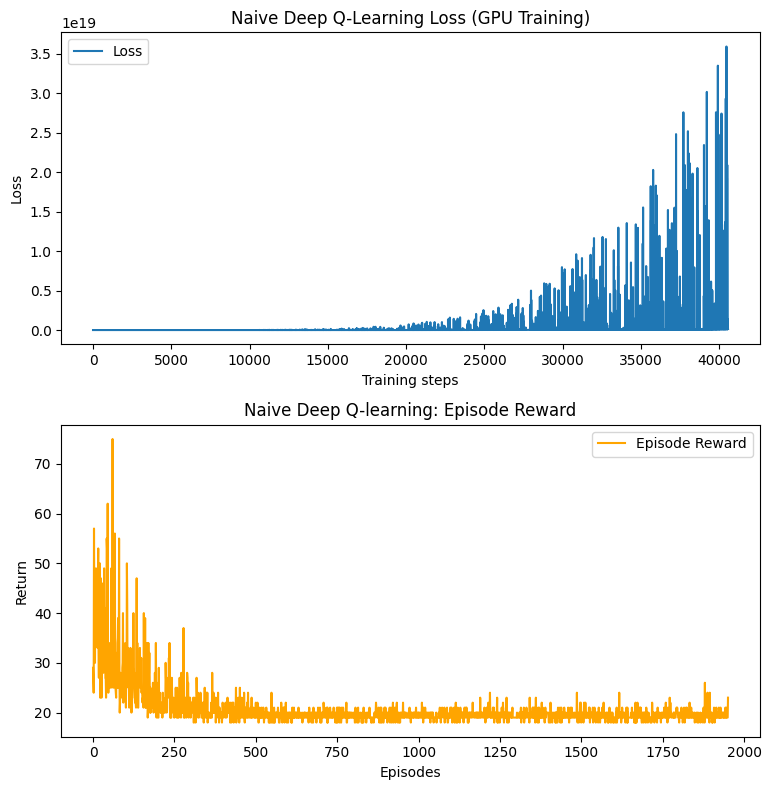

In [ ]:
plt.ioff()


fig, (ax_loss, ax_reward) = plt.subplots(2, 1, figsize=(8, 8))

line_loss, = ax_loss.plot([], [], label='Loss')
ax_loss.set_xlabel('Training steps')
ax_loss.set_ylabel('Loss')
ax_loss.set_title("Naive Deep Q-Learning Loss (GPU Training)")

line_reward, = ax_reward.plot([], [], label='Episode Reward', color='orange')
ax_reward.set_xlabel('Episodes')
ax_reward.set_ylabel('Return')
ax_reward.set_title("Naive Deep Q-learning: Episode Reward")

ax_loss.legend()
ax_reward.legend()

plt.tight_layout()

for episode in range(num_episodes): 

    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        # Pass device argument to the eps_greedy function
        action = eps_greedy(q, state, epsilon, env, device)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        ep_reward += reward

        # Compute target: move next_state tensor to device
        with torch.no_grad():
            next_state_t = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            # The q(next_state_t) calculation is on the GPU, result is moved to CPU by .item()
            target = reward + gamma * q(next_state_t).max().item()

        # Prediction: move current state tensor to device
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = q(state_t)
        q_value = q_values[0, action] # This tensor is on the GPU

        # Loss and gradient step remains the same (calculated on GPU)
        loss = (q_value - target) ** 2 

        # Gradient step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

        state = next_state

        global_step += 1
        
        # Move loss to CPU before appending to list
        loss_history.append(loss.item())    
        loss_steps.append(global_step)

    # Epsilon decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    episodes_rewards.append(ep_reward)

    if episode % 100 == 0:
        print(f"Episode {episode+1}, Reward: {ep_reward}, Epsilon: {epsilon:.3f}")

    if episode % 50 == 0:
        line_loss.set_data(loss_steps, loss_history)
        line_reward.set_data(range(len(episodes_rewards)), episodes_rewards)
        # ⬅️ FONDAMENTALE: Ricalcola i limiti dei dati
        ax_loss.relim(); ax_loss.autoscale_view()
        ax_reward.relim(); ax_reward.autoscale_view()


plt.show()

In [ ]:
print("\n\n\n\n🎉 FINAL PERFORMANCE:\n\n\n")
for i in range(render_episodes):
    final_score = run_render_episode(q, render_env, device)
    print(f"Final Score: {final_score}")